# Next Chord prediction using Deep Learning on AWS

This notebook lists all the steps that you need to complete the complete this project.

This notebook contains the code to:

1. Create a Hyperparameter Tuning job to tune three parameters for an image classification model using transfer learning.
2. Get the best hyperparameter combinations and create a final model using those. Also, add debugger and profiler to monitor the training.
3. Deploy the resulting model to an endpoint and check if it works by querying it.
4. Delete any active endpoints.

In [1]:
# Install any packages that you might need
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import any packages that you might need
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

In [4]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [5]:
data = 's3://project-soungprogress-database/dataset'

## Hyperparameter Tuning
This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [45]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([32,64]),
    "epochs": IntegerParameter(20,30)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [46]:
# Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="pytorch_chords_hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [47]:
# Fit your HP Tuner
tuner.fit({"training": data}) # data channel

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................

KeyboardInterrupt: 

In [44]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

Exception: Best training job not available for tuning job: pytorch-training-230203-2016

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs, ProfilerRule
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)

In [23]:
# Create and fit an estimator

hyperparameters = {
    "batch-size": "64",
    "epochs": "2",
    "lr": "0.0031691594104431555"
}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version="py36",
    framework_version="1.8",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

estimator.fit({"train": inputs})

2023-01-03 22:20:49 Starting - Starting the training job...
2023-01-03 22:21:14 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-01-03 22:22:20 Downloading - Downloading input data......
2023-01-03 22:23:16 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-03 22:23:23,234 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-03 22:23:23,237 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-03 22:23:23,245 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-03 22:23:23,247 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-03 22:23:23,402 sagemaker-

In [34]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: dogImageClassifier-2023-01-03-22-20-49-041
Region: us-east-1


In [35]:
# Plot a debugging output
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-03 22:57:23.696 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/debug-output


In [36]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-01-03 22:57:25.098 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-03 22:57:26.119 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight', 'gradient/ResNet_layer1.1.bn2.bias', 'gradient/ResNet_layer1.1.bn2.weight', 'gradient/ResNet_layer1.1.conv1.weight', 'gradient/ResNet_layer1.1.conv2.weight', 'gradient/ResNet_layer2.0.bn1.bias', 'gradient/ResNet_layer2.0.bn1.

In [37]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)

In [38]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/rule-output


In [39]:
! aws s3 ls {rule_output_path} --recursive

2023-01-03 22:44:41     376369 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-03 22:44:40     224328 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-03 22:44:35        192 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-03 22:44:35        200 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-03 22:44:35       1821 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-03 22:44:35        127 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-03 22:44:35        199 dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-outp

In [40]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-761422902711/dogImageClassifier-2023-01-03-22-20-49-041/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-761422902711/dogImageClassi

In [41]:
# Display the profiler output
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [42]:
# TODO: Plot a debugging output.

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


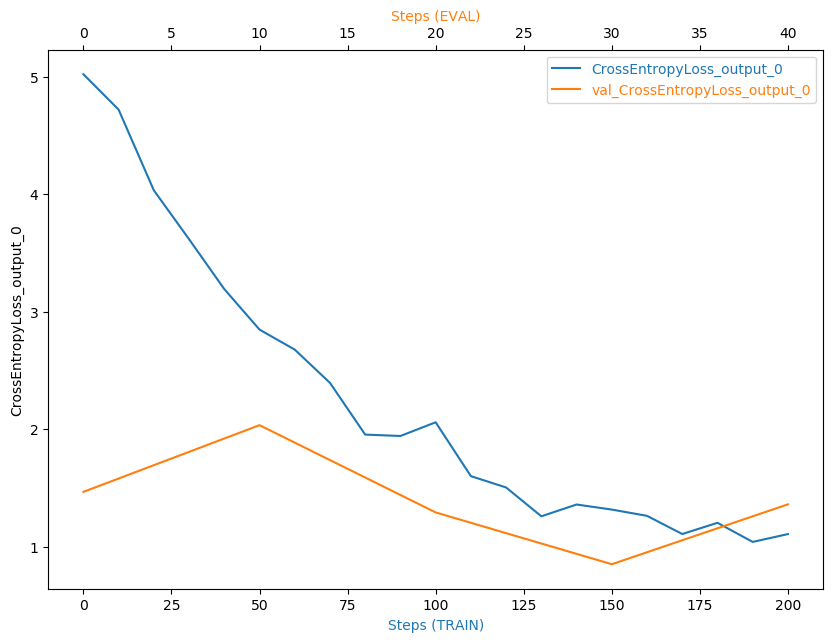

In [44]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

The output graph is normal. The training loss decreases and the validation loss first decreases and then increases a litte bit. If the loss was not decreasing, we could change some hyperparameters and train again.

## Model Deploying

In [97]:
# loading the model manually from its location in S3
model_location = estimator.model_data

In [98]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py', py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [99]:
# Deploy your model to an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # Add your deployment configuration like instance type and number of instances

------!

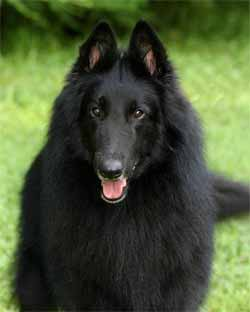

In [100]:
# Run an prediction on the endpoint
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

# code to load and preprocess image to send to endpoint for prediction
img_file_name = "dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01477.jpg"
with open(img_file_name, "rb") as f:
    payload = f.read()
    
type(payload)

from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [101]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-1.7371129989624023,
  -0.8418782949447632,
  -4.94460391998291,
  -3.512251853942871,
  -3.6502273082733154,
  -2.1465816497802734,
  -6.069096565246582,
  -4.904167652130127,
  -3.824039936065674,
  -4.874552249908447,
  -3.8817708492279053,
  -3.226146936416626,
  -2.8008170127868652,
  -4.612435817718506,
  -4.227658748626709,
  -7.0696001052856445,
  -4.846362113952637,
  -2.2360739707946777,
  -4.91444730758667,
  -4.197338104248047,
  2.412445545196533,
  -0.7682673931121826,
  -2.5183756351470947,
  -5.476358890533447,
  -4.103819847106934,
  -3.9531819820404053,
  -4.248432159423828,
  -4.36891508102417,
  -0.979539692401886,
  -6.56720495223999,
  -3.118551015853882,
  -6.061729907989502,
  -3.078287363052368,
  -6.963152885437012,
  -3.112856149673462,
  -3.5132923126220703,
  -6.133740425109863,
  -5.9434967041015625,
  -5.1908745765686035,
  -7.360300064086914,
  -5.320185661315918,
  -4.485443592071533,
  -3.95955228805542,
  -3.2369349002838135,
  -4.524960517883301,
 

In [105]:
import numpy as np
np.argmax(response, 1) + 1

array([21])

In [103]:
# Shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()